In [1]:
import pandas as pd
import os
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, RocCurveDisplay, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

2025-08-13 09:15:49.375223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755076549.590273      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755076549.651380      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_labels = pd.read_csv("/kaggle/input/raf-db-dataset/train_labels.csv")
test_labels = pd.read_csv("/kaggle/input/raf-db-dataset/test_labels.csv")
print(train_labels.head())

                     image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5


In [3]:
classes = ["surprise", "fear", "disgust", "happy", "sad", "angry", "neutral"]
label_map = {label: (idx + 1) for idx, label in enumerate(classes)}
print(label_map)

{'surprise': 1, 'fear': 2, 'disgust': 3, 'happy': 4, 'sad': 5, 'angry': 6, 'neutral': 7}


In [4]:
def load_data(dataset_dir, label_map):
    images = []
    labels = []
    
    for label, idx in tqdm(label_map.items()):
        folder_path = os.path.join(dataset_dir, str(idx))
        
        if not os.path.exists(folder_path):
            continue
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            images.append(img_rgb)
            labels.append(idx)
    
    return np.array(images), np.array(labels)

In [5]:
train_images, train_labels = load_data('/kaggle/input/raf-db-dataset/DATASET/train', label_map)
test_images, test_labels = load_data('/kaggle/input/raf-db-dataset/DATASET/test', label_map)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
print(train_images.shape)
print(test_images.shape)


(12271, 100, 100, 3)
(3068, 100, 100, 3)


In [7]:
total_images = len(train_images) + len(test_images)

train_percentage = (len(train_images) / total_images) * 100
test_percentage = (len(test_images) / total_images) * 100


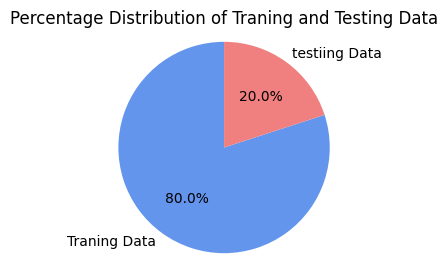

In [8]:
labels = ['Traning Data', 'testiing Data']
sizes = [train_percentage, test_percentage]
colors = ['cornflowerblue', 'lightcoral']
plt.figure(figsize=(3,3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution of Traning and Testing Data')
plt.axis('equal')
plt.show()

In [9]:
from collections import Counter

# Count occurrences of each label
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Train data class counts
train_classes = sorted(train_label_counts.keys())
train_count = [train_label_counts[cls] for cls in train_classes]

# Test data class counts
test_classes = sorted(test_label_counts.keys())
test_count = [test_label_counts[cls] for cls in test_classes]



In [10]:
total_train = sum(train_count)
total_test = sum(test_count)

train_percentages = [(count / total_train) * 100 for count in train_count]
test_percentages = [(count / total_test) * 100 for count in test_count]




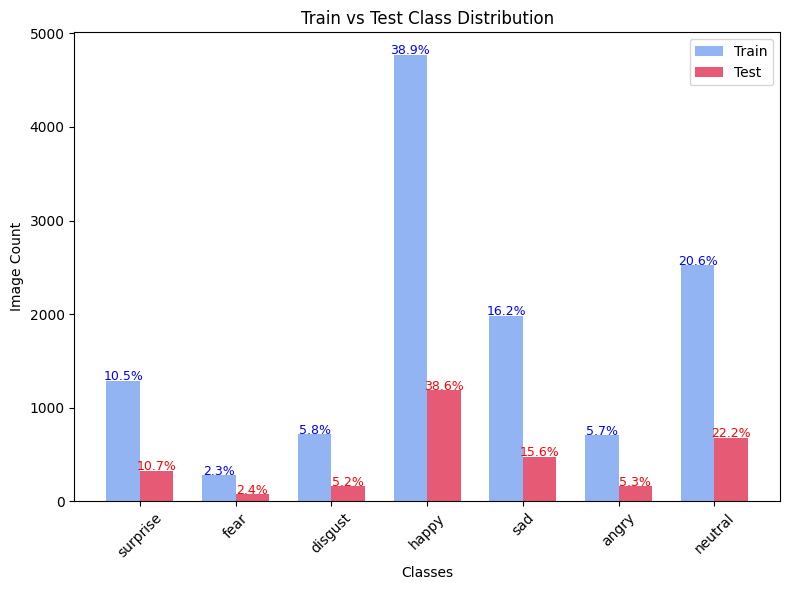

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
x = range(len(classes))
bar_width = 0.35

# Train bars
plt.bar(x, train_count, width=bar_width, label="Train", alpha=0.7, color="cornflowerblue")

# Test bars (shifted by bar_width)
plt.bar([p + bar_width for p in x], test_count, width=bar_width, label="Test", alpha=0.7, color="crimson")
for i, (train_c, test_c) in enumerate(zip(train_count, test_count)):
    # Train percentage text
    plt.text(i, train_c + 5, f"{train_percentages[i]:.1f}%", 
             ha='center', color='blue', fontsize=9)
    
    # Test percentage text (shift x position by bar_width)
    plt.text(i + bar_width, test_c + 5, f"{test_percentages[i]:.1f}%", 
             ha='center', color='red', fontsize=9)

# Add labels and formatting
plt.xlabel("Classes")
plt.ylabel("Image Count")
plt.title("Train vs Test Class Distribution")
plt.xticks([p + bar_width / 2 for p in x], classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
X_train = np.concatenate([train_images, test_images], axis=0)
Y_train = np.concatenate([train_labels, test_labels], axis=0)

print(X_train.shape)
print(Y_train.shape)


(15339, 100, 100, 3)
(15339,)


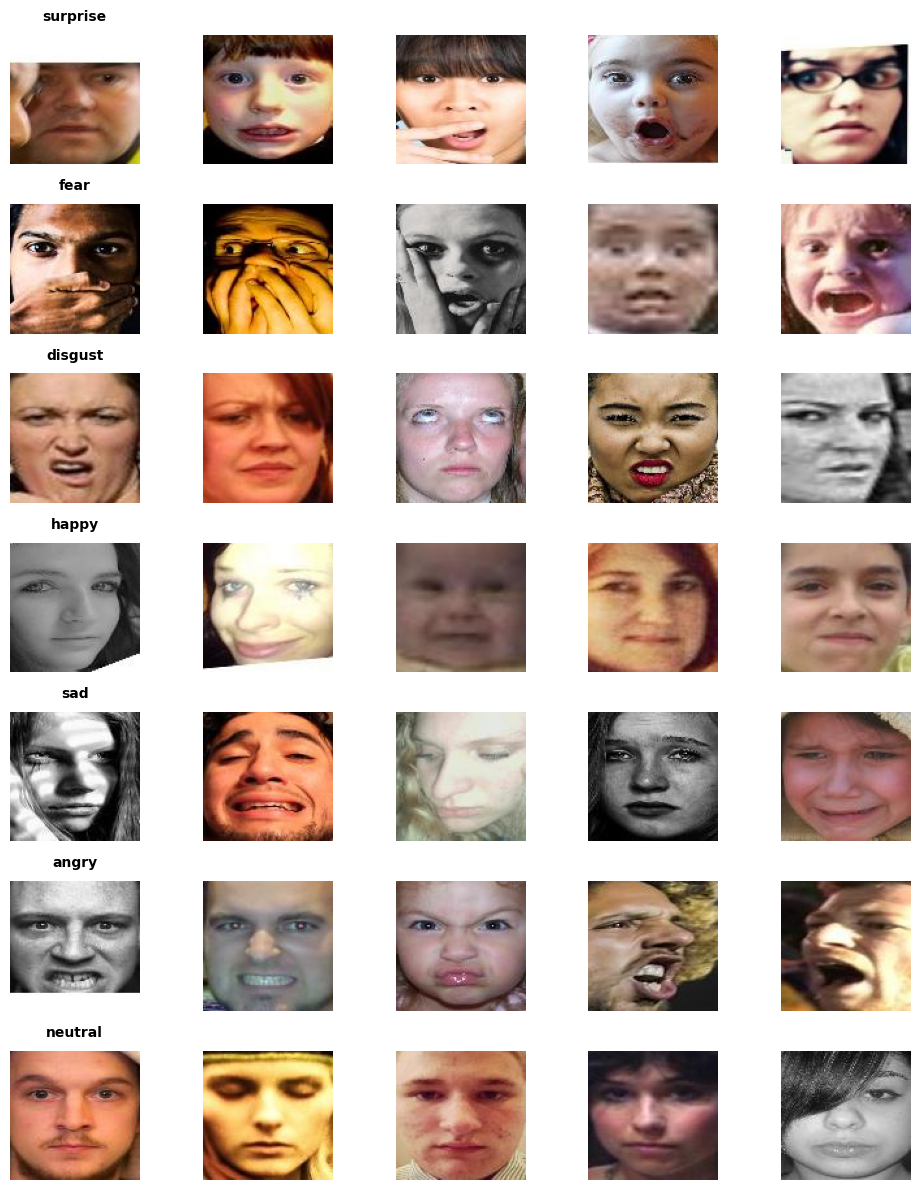

In [13]:

def show_examples(train_images, train_labels, classes, num_examples=5):
    num_classes = len(classes)
    
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 12))
    
    for i, class_name in enumerate(classes):
        # Find indices for current class
        class_indices = [idx for idx, label in enumerate(train_labels) if label == i+1]  # assuming labels start at 1
        
        # Select random samples
        selected_indices = np.random.choice(class_indices, num_examples, replace=False)
        
        # Set row title
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        
        # Plot each image for the current class
        for j, idx in enumerate(selected_indices):
            img = train_images[idx]
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
show_examples(X_train, Y_train, classes)



In [14]:
train_data_shapes = []

# Collect shapes of all images
for img in X_train:
    train_data_shapes.append(img.shape)

# Count shape occurrences
shape_counts = {}
for shape in train_data_shapes:
    if shape not in shape_counts:
        shape_counts[shape] = 0
    shape_counts[shape] += 1

# Sort by frequency (most common shapes first)
sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 3 most frequent shapes
print("Most frequent Train image shapes:")
for shape, count in sorted_shapes[:3]:
    print(f"- {shape}: {count}")


Most frequent Train image shapes:
- (100, 100, 3): 15339


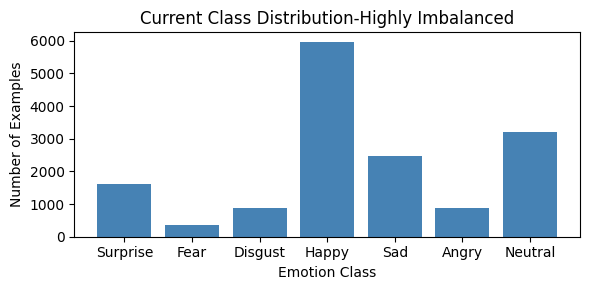

In [15]:
def plot_class_distribution(y, title):
    # Count class occurrences
    train_label_counts_resampled = Counter(y)

    # Sort classes
    train_classes_resampled = sorted(train_label_counts_resampled.keys())
    train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]

    # Emotion class labels
    x_labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']

    # Plot
    plt.figure(figsize=(6, 3))
    plt.bar(x_labels, train_counts_resampled, color="steelblue")
    plt.xlabel("Emotion Class")
    plt.ylabel("Number of Examples")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_class_distribution(Y_train, 'Current Class Distribution-Highly Imbalanced')

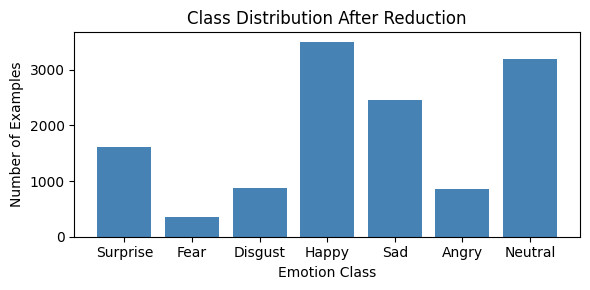

In [16]:
def reduce_class(X, y, target_class, target_size):
    # Separate the target class
    class_indices = np.where(y == target_class)[0]
    non_class_indices = np.where(y != target_class)[0]

    # Randomly sample the target class to the desired size
    reduced_class_indices = np.random.choice(class_indices, target_size, replace=False)

    # Combine reduced target class with all other classes
    final_indices = np.concatenate([reduced_class_indices, non_class_indices])

    # Get reduced data
    X_reduced = X[final_indices]
    y_reduced = y[final_indices]

    return X_reduced, y_reduced

# Reduce the 'happy' class (label 4) to 3500 samples
target_class = 4  # The 'happy' class
target_size = 3500

X_train_reduced, y_train_reduced = reduce_class(X_train, Y_train, target_class, target_size)

# Plot new distribution
plot_class_distribution(y_train_reduced, "Class Distribution After Reduction")

In [17]:
def augment_classes(images, labels, target_counts):
    # Initialize augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        vertical_flip=False,
        horizontal_flip=True,
        channel_shift_range=50.0,
        fill_mode='nearest'
    )

    # Copy original data
    augmented_images = images.copy()
    augmented_labels = labels.copy()

    # Loop through each target class and augment
    for target_class, target_count in target_counts.items():
        # Get images and labels for the current class
        class_images = images[labels == target_class]
        class_labels = labels[labels == target_class]

        # Calculate how many more samples are needed
        augment_count = target_count - len(class_images)

        if augment_count > 0:
            print(f"Class {target_class}: {len(class_images)} original samples, augmenting with {augment_count}")

            class_images_augmented = []
            class_labels_augmented = []

            # Generate augmented images
            for batch in datagen.flow(class_images, batch_size=1, seed=42):
                aug_image = batch[0].astype(np.uint8)
                class_images_augmented.append(aug_image)
                class_labels_augmented.append(target_class)

                if len(class_images_augmented) >= augment_count:
                    break

            # Append augmented data to dataset
            augmented_images = np.vstack((augmented_images, np.array(class_images_augmented)))
            augmented_labels = np.hstack((augmented_labels, np.array(class_labels_augmented)))

    return augmented_images, augmented_labels


# Target counts for each class
target_counts = {
    1: 3500,
    2: 3500,
    3: 3500,
    5: 3500,
    6: 3500,
    7: 3500
}

# Usage
X_train_augmented, y_train_augmented = augment_classes(
    X_train_reduced,
    y_train_reduced,
    target_counts
)

Class 1: 1619 original samples, augmenting with 1881
Class 2: 355 original samples, augmenting with 3145
Class 3: 877 original samples, augmenting with 2623
Class 5: 2460 original samples, augmenting with 1040
Class 6: 867 original samples, augmenting with 2633
Class 7: 3204 original samples, augmenting with 296


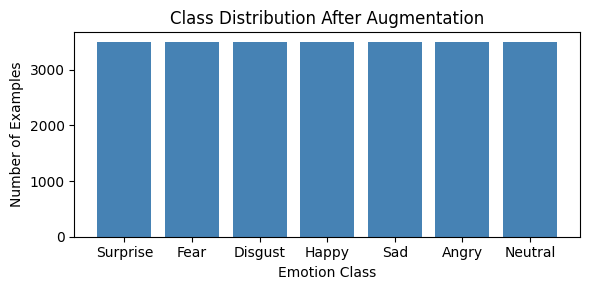

In [18]:
plot_class_distribution(y_train_augmented, "Class Distribution After Augmentation")

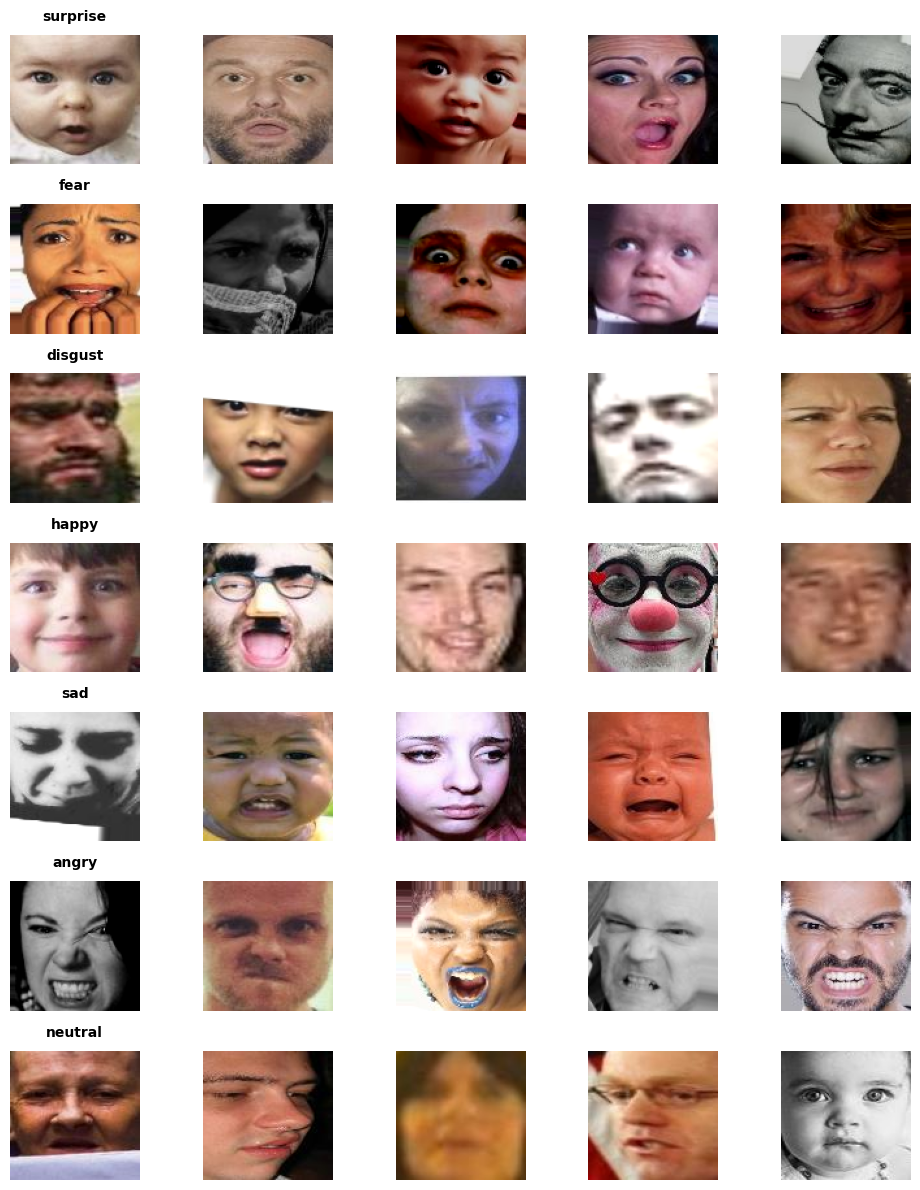

In [19]:
show_examples(X_train_augmented, y_train_augmented, classes)


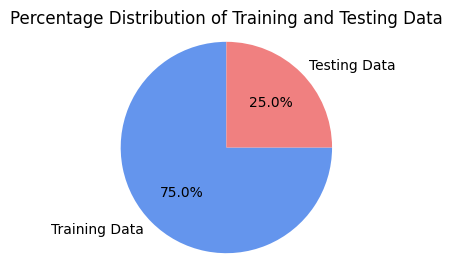

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_augmented,
    y_train_augmented,
    test_size=0.25,
    shuffle=True,
    random_state=42
)

# Calculate percentages
total_images = len(X_train) + len(X_test)
train_percentage = (len(X_train) / total_images) * 100
test_percentage = (len(X_test) / total_images) * 100

# Labels and sizes for pie chart
labels = ['Training Data', 'Testing Data']
sizes = [train_percentage, test_percentage]
colors = ['cornflowerblue', 'lightcoral']

# Plot pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')  # Equal aspect ratio ensures pie chart is circular
plt.show()


In [21]:
def normalize_images(images):
    return images / 255.0  # Normalize pixel values to [0,1]

# Normalize train and test images
train_images_normalized = normalize_images(X_train)
test_images_normalized = normalize_images(X_test)


In [22]:
def reshape_images(images):
    return images.reshape((images.shape[0], 100, 100, 3))

# Reshape normalized images
train_images_reshaped = reshape_images(train_images_normalized)
test_images_reshaped = reshape_images(test_images_normalized)



In [23]:
print(f"Training images shape: {train_images_reshaped.shape}")

print(f"Testing images shape: {test_images_reshaped.shape}")

Training images shape: (18375, 100, 100, 3)
Testing images shape: (6125, 100, 100, 3)


In [24]:


# Convert labels to one-hot encoding (subtract 1 for 0-based indexing)
Y_train_cat = to_categorical(Y_train - 1, num_classes=len(classes))
Y_test_cat = to_categorical(Y_test - 1, num_classes=len(classes))


In [25]:

# Initialize ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=False,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create augmented data generator
train_generator = datagen.flow(
    train_images_reshaped,   # Make sure this variable matches your reshaped normalized data
    Y_train_cat,
    batch_size=64
)


In [26]:

# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=test_images_reshaped[0].shape),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(len(classes), activation='softmax')
])

# Compile model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-13 09:18:36.273217: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,881,991 (18.62 MB)

 Trainable params: 4,881,991 (18.62 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=10,
    min_delta=0.0001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_CNNModel.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
CNN_History = cnn_model.fit(
    train_generator,
    epochs=10,  # Suggested: 50–60 for better results
    batch_size=32,
    validation_data=(test_images_reshaped, Y_test_cat),
    callbacks=[reduce_lr, early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.2057 - loss: 1.8953
Epoch 1: val_accuracy improved from -inf to 0.33045, saving model to best_CNNModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 232s 794ms/step - accuracy: 0.2058 - loss: 1.8951 - val_accuracy: 0.3304 - val_loss: 1.7311 - learning_rate: 0.0010
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.3182 - loss: 1.7270
Epoch 2: val_accuracy improved from 0.33045 to 0.47918, saving model to best_CNNModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 228s 790ms/step - accuracy: 0.3183 - loss: 1.7268 - val_accuracy: 0.4792 - val_loss: 1.3690 - learning_rate: 0.0010
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.4386 - loss: 1.4699
Epoch 3: val_accuracy improved from 0.47918 to 0.55592, saving model to best_CNNModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 233s 807ms/step - accuracy: 0.4386 - loss: 1.4697 - val_accuracy: 0.5559 - val_loss: 1.1739 - learning_rate: 0.0010
Epoch 4/10
288/288 ━━━━━━━━━

In [28]:
# After training finishes
cnn_model.save("emotion_model.keras")
print("Model saved as emotion_model.keras")


Model saved as emotion_model.keras


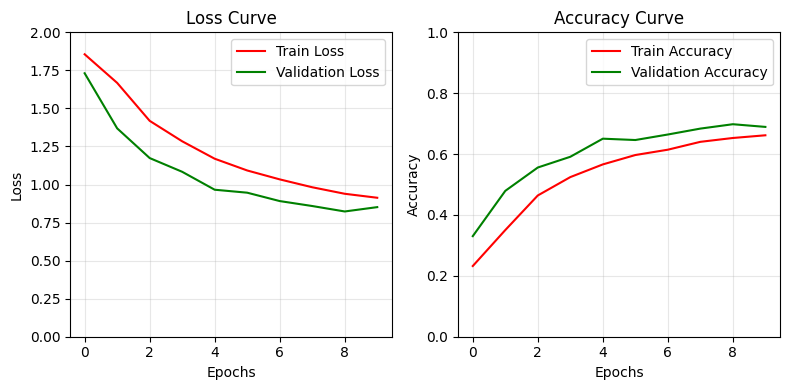

In [29]:
# Extract history data
train_loss = CNN_History.history['loss']
val_loss = CNN_History.history['val_loss']
train_accuracy = CNN_History.history['accuracy']
val_accuracy = CNN_History.history['val_accuracy']

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# ---- Plot Loss ----
ax[0].plot(train_loss, label='Train Loss', color='red')
ax[0].plot(val_loss, label='Validation Loss', color='green')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([0, 2])  # Adjust based on your loss range
ax[0].grid(alpha=0.3)

# ---- Plot Accuracy ----
ax[1].plot(train_accuracy, label='Train Accuracy', color='red')
ax[1].plot(val_accuracy, label='Validation Accuracy', color='green')
ax[1].set_title('Accuracy Curve')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim([0, 1])
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [30]:
# Evaluate on training and testing datasets
train_CNNresult = cnn_model.evaluate(train_images_reshaped, Y_train_cat)
test_CNNresult = cnn_model.evaluate(test_images_reshaped, Y_test_cat)

# Print results
print("Train Loss: {:.2f}%".format(train_CNNresult[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_CNNresult[1] * 100))

print("\nTest Loss: {:.2f}%".format(test_CNNresult[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_CNNresult[1] * 100))


575/575 ━━━━━━━━━━━━━━━━━━━━ 52s 90ms/step - accuracy: 0.7276 - loss: 0.7484
192/192 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.7028 - loss: 0.8232
Train Loss: 74.88%
Train Accuracy: 72.60%

Test Loss: 82.30%
Test Accuracy: 69.81%
